In [1]:
import tensorflow as tf
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is available


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
sns.set(style="dark")
from random import random, choice
from functools import reduce
from itertools import product


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/DOL/Project2/

/content/drive/MyDrive/DOL/Project2


In [5]:
!git clone https://github.com/sevgicansalih/nwdaf_data

Cloning into 'nwdaf_data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 4), reused 9 (delta 1), pack-reused 0
Receiving objects: 100% (19/19), 13.79 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [6]:
data = pd.read_csv('nwdaf_data/nwdaf_data.csv')
data = data.drop(columns='has_anomaly')

In [7]:
cell0 = data.loc[data['cell_id']==0]
cell1 = data.loc[data['cell_id']==1]
cell2 = data.loc[data['cell_id']==2]
cell3 = data.loc[data['cell_id']==3]
cell4 = data.loc[data['cell_id']==4]

In [8]:
week = 4*24*7

In [9]:
load_cell0 = cell0.groupby('t')['load'].sum()[:8*week]
load_cell1 = cell1.groupby('t')['load'].sum()[:8*week]
load_cell2 = cell2.groupby('t')['load'].sum()[:8*week]
load_cell3 = cell3.groupby('t')['load'].sum()[:8*week]
load_cell4 = cell4.groupby('t')['load'].sum()[:8*week]

In [10]:
load_cells=[load_cell0, load_cell1, load_cell2, load_cell3, load_cell4]

In [11]:
look_back = week
def df_to_X_y(df, look_back=5):
  # df_as_np = df.to_numpy()
  df_as_np = df
  X = []
  y = []
  for i in range(len(df_as_np)-look_back):
    row = [[a] for a in df_as_np[i:i+look_back]]
    X.append(row)
    label = df_as_np[i+look_back]
    y.append(label)
  return np.array(X), np.array(y)

In [12]:
class Client():
  def __init__(self, cid, load_cell, n_epoch = 1, n_batch = 64, lr=0.001, validation_split = 0.2, verbosity = 2, neighbours_vector=[1, 1, 1, 1, 1], client_selection="random"):
    self.cid = cid

    # Data Preprocessing
    self.scaler = MinMaxScaler()
    load_cell = load_cell.to_numpy().reshape(-1, 1)
    self.scaled_load_cell = self.scaler.fit_transform(load_cell)
    x_cell, y_cell = df_to_X_y(self.scaled_load_cell, look_back)
    self.x_train, self.x_test, self.y_train, self.y_test= train_test_split(x_cell, y_cell, test_size=0.2, shuffle=False)
    self.x_train = self.x_train.reshape(self.x_train.shape[0],self.x_train.shape[1],self.x_train.shape[2])
    self.x_test = self.x_test.reshape(self.x_test.shape[0],self.x_test.shape[1],self.x_test.shape[2])

    # Learning parameters
    self.n_epoch = n_epoch
    self.n_batch = n_batch
    self.lr = lr
    self.validation_split = validation_split
    self.verbosity = verbosity
    self.loss_function = MeanSquaredError()
    self.metrics = RootMeanSquaredError()
    self.optimizer = Adam(learning_rate = self.lr)

    # To store the evaluation of each round
    self.test_losses = []
    self.train_losses = []
    self.histories = []



    # find neighbours from the neighbours_vector and create adjacent_vector
    self.neighbours = [index for index, element in enumerate(neighbours_vector) if element != 0]
    print(f"Neighbour for client {cid}:",  self.neighbours) # Log
    self.adjacent_vector = np.zeros(len(neighbours_vector))
    for n_id in self.neighbours:
       self.adjacent_vector[n_id] = 1/len(self.neighbours)

    self.compromised = False
    self.robustness = False


    self.client_selection = client_selection
    self.model = self._create_model()

    print(f"client {cid} initilized.")

  def _create_model(self):
    model = Sequential()
    model.add(LSTM(50, return_sequences = True, input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(LSTM(units = 50))
    model.add(Dropout(0.3))
    model.add(Dense(units = 8, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, activation = 'linear'))
    return model

  def _model_compile(self):
    self.model.compile(loss=self.loss_function, optimizer= self.optimizer, metrics=[self.metrics])

  def update_adjacent_vector(self, clients):

    # If one agent be compromised, It doen't need to use neighbours' model.
    if self.compromised:
        self.adjacent_vector = np.zeros(len(self.adjacent_vector))
        self.adjacent_vector[self.cid] = 1
        return


    if self.client_selection == "random":
      # In the random client selection, we change adjacent vector randomly.
      random_numbers = np.random.rand(len(self.neighbours)-1)
      random_numbers = np.sort(random_numbers)

      # Adding 0 at the beginning and 1 at the end
      random_numbers = np.append(random_numbers, 1)
      random_numbers = np.insert(random_numbers, 0, 0)

      random_weights = np.diff(random_numbers)
      for i, n_id in enumerate(self.neighbours):
        self.adjacent_vector[n_id] = random_weights[i]

    elif self.client_selection == "pow":
      # The POWER-OF-CHOICE Client Selection Strategy, we change the adjacent vector according to local loss at the current client model.
      test_losses = dict()
      for client in clients.values():
        if client.cid in self.neighbours:
          test_losses[client.cid] = client.evaluate(self.x_test, self.y_test)

      for n_id in self.neighbours:
        self.adjacent_vector[n_id] = test_losses[n_id]/sum(test_losses.values())

    elif self.client_selection =="div":
      # Ref: https://github.com/euphoria0-0/Active-Client-Selection-for-Communication-efficient-Federated-Learning/blob/main/src/FL_core/client_selection/divfl.py
      # Find the `representative gradient` formed by the difference between the local work and the sent global model (get clients' gradients)
      local_model_grads = []
      for client in clients.values():
        if client.cid in self.neighbours:
          local_model_grads += [x - y for x, y in zip(client.get_weights(), self.get_weights())]

      # Find the similarity matrix where the distance chosen to compare two clients is set with `distance_type`
      n_clients = len(self.neighbours)
      metric_matrix = np.zeros((n_clients, n_clients))
      for i, j in product(range(n_clients), range(n_clients)):
        grad_1, grad_2 = local_model_grads[i], local_model_grads[j]
        for g_1, g_2 in zip(grad_1, grad_2):
          metric_matrix[i, j] += np.sum(np.square(g_1 - g_2))

      # num_clients is the target number of selected clients each round, subsample is a parameter for the stochastic greedy alg initialize the ground set and the selected set
      V_set = set(range(n_clients))
      SUi = set()
      num_select_clients = 2
      m = num_select_clients
      for ni in range(num_select_clients):
        if m < len(V_set):
          R_set = np.random.choice(list(V_set), m, replace=False)
        else:
          R_set = list(V_set)
        if ni == 0:
          marg_util = metric_matrix[:, R_set].sum(0)
          i = marg_util.argmin()
          client_min = metric_matrix[:, R_set[i]]
        else:
          client_min_R = np.minimum(client_min[:, None], metric_matrix[:, R_set])
          marg_util = client_min_R.sum(0)
          i = marg_util.argmin()
          client_min = client_min_R[:, i]
        SUi.add(self.neighbours[R_set[i]])
        V_set.remove(R_set[i])

      print("Selected Client: ", SUi) #Log
      for n_id in range(len(self.adjacent_vector)):
        if n_id in SUi:
          self.adjacent_vector[n_id]=1/len(SUi)
        else:
          self.adjacent_vector[n_id] = 0
      return SUi

  def consensus(self, clients):
    results=[]
    selected_neighbours= [indx for indx, weight in enumerate(self.adjacent_vector) if weight > 0 ]

    for neighbour_id in selected_neighbours:
      model = clients[neighbour_id].get_weights()
      edge_weight = self.adjacent_vector[neighbour_id]
      results.append((model, edge_weight))

    # Log
    print("adjacent_weight: ",[(i, self.adjacent_vector[i]) for i in range(len(self.adjacent_vector))])

    model_params = [
        [layer * edge_weight for layer in weights] for weights, edge_weight in results
    ]

    weights_prime: np.ndarray = [
        reduce(np.add, layer_updates)
        for layer_updates in zip(*model_params)
    ]

    return weights_prime


  def fit(self, clients):
    # Find Compromised neighbours
    if self.robustness:
      self.find_Compromised(clients)

    # Client Selection and selected neighbours consensus
    self.update_adjacent_vector(clients)
    model_params = self.consensus(clients)

    # Train model
    self.model.set_weights(model_params)
    self._model_compile()

    if self.compromised:
      x_trian = self.attack()
      y_train= self.y_targeted
    else:
      x_trian = self.x_train
      y_train = self.y_train

    model_histoty = self.model.fit(x_trian, y_train, epochs=self.n_epoch, batch_size=self.n_batch, shuffle=False, verbose= self.verbosity, validation_split= self.validation_split)

    # Save metrices
    self.test_losses.append(self.evaluate(self.x_test, self.y_test))
    self.train_losses.append(self.evaluate(self.x_train, self.y_train))
    self.histories.append(model_histoty)


  def predict(self, x):
    return self.model.predict(x).flatten()

  def evaluate(self, x, y):
    cell_predictions = self.predict(x)
    cell_results = pd.DataFrame(data={'Test Predictions':cell_predictions, 'Actuals':y.reshape(y.shape[0])})
    inv_pred_cell = self.scaler.inverse_transform(cell_results['Test Predictions'].to_numpy().reshape(-1,1))
    inv_acc_cell = self.scaler.inverse_transform(cell_results['Actuals'].to_numpy().reshape(-1,1))
    return mean_squared_error(y_pred=inv_pred_cell, y_true=inv_acc_cell)

  def get_weights(self):
    allLayersWeights = self.model.get_weights()
    return allLayersWeights

  def set_weights(self, w):
    self.model.set_weights(w)

  def set_compromised(self):
    self.compromised = True
    self.y_targeted = self.y_train - 0.4
    self.targeted_attack = Targeted_attack()


  def set_robustness(self):
    self.robustness = True
    self.threshold = 500
    self.neighbours_loss = dict()
    for cid in self.neighbours:
      self.neighbours_loss[cid]=[]

  def find_Compromised(self, clients):
    # Check the loss of neighbour's model with own data test.
    for client in clients.values():
      if client.cid in self.neighbours:
        self.neighbours_loss[client.cid].append(client.evaluate(self.x_test, self.y_test))
    detected_cid = None
    for cid, loss in self.neighbours_loss.items():
      if len(loss) >=3:
        total_loss = sum([loss[-1], loss[-2], loss[-3]])
      else:
        total_loss = sum(loss)
      print(f"client {cid} sum: {total_loss} ")
      if total_loss >= self.threshold and self.cid != cid:
        print(f"Client {cid} is detected as an attacker!")
        detected_cid = cid
        self.neighbours.remove(detected_cid)
        self.adjacent_vector[detected_cid] = 0
    if detected_cid != None:
      self.neighbours_loss.pop(detected_cid)

  def attack(self):
    x_adv = self.targeted_attack.targetd_PGD(x=self.x_train, targeted_y= self.y_targeted, model = self.model, epsilon=0.5 , steps=3)
    return x_adv

In [13]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from keras.backend import sign

In [14]:
class Targeted_attack():
  def __init__(self):
    pass

  def targetd_FGSM(self, x, targeted_y, model, epsilon):
    # Collect the element-wise sign of the data gradient
    y_pred = model.predict(x).reshape(-1,1)
    loss = MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(targeted_y, y_pred)
    data_gradient = np.gradient(loss)
    sign_data_gradient = sign(data_gradient).numpy()

    # Create the perturbed data by adjusting each sample of the input data
    # perturbed_data = x + epsilon*sign_data_gradient
    perturbed_data = np.zeros(x.shape)
    for i in range(len(x)):
      for j in range(len(x[i])):
        perturbed_data[i,j] = x[i,j] - epsilon*sign_data_gradient[i]
    # Return the perturbed data
    return perturbed_data

  def targetd_FGSM_tf(self, x, targeted_y, model, epsilon):
    loss_object = MeanSquaredError()
    input_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as tape:
      tape.watch(input_tensor)
      prediction = model(x)
      loss = loss_object(targeted_y, prediction)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_tensor)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    adv_x = x - epsilon * signed_grad
    return adv_x



  def targetd_PGD(self, x, targeted_y, model , epsilon, steps):
    # Starting at a uniformly random point, which noise is uniform distribution -e,e
    x_noise = x + np.random.uniform(low=-epsilon, high=epsilon)
    x_clip= np.clip(x_noise, a_min=0, a_max=1)
    for _ in range(steps):
      X_perturbed = self.targetd_FGSM(x=x, targeted_y=targeted_y, model=model, epsilon=epsilon)
      delta = np.clip(X_perturbed - x, a_min=-epsilon, a_max=epsilon)
      X_perturbed = np.clip(x + delta, a_min=0, a_max=1)
    # in multiple steps update addverserial data with Projected Gradient Descent.
    # P is Clip operation P(z)= clip(z, x-e, x+e)
    return X_perturbed

  def mAPGD_TSF():
    pass

In [15]:
def initialize_clients(num_clients, n_epoch = 1, n_batch = 64, lr=0.001, validation_split = 0.2, verbosity = 2, adjacent_metrix = [[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]], client_selection="random"):
  print("Initializing clients ...")
  clients = dict()
  for cid in range(num_clients):
    clients[cid] = Client(cid=cid,
                          load_cell=load_cells[cid],
                          n_epoch = n_epoch,
                          n_batch = n_batch,
                          lr=lr,
                          validation_split = validation_split,
                          verbosity = verbosity,
                          neighbours_vector = adjacent_metrix[cid],
                          client_selection = client_selection
                          )
  print("Clients initialized!")
  return clients

In [16]:
# Plot each cell loss in test set in each round
def plot_cell_loss(clients):
  for client in clients:
    plt.plot(client.test_losses, label=f"cell {client.cid}")
  plt.legend()
  plt.grid(True)
  plt.show()

In [17]:
def run_fd(clients, num_rounds):
  for round in range(num_rounds):
    for client in clients.values():
      print(f"round {round} client {client.cid}: ")
      client.fit(clients)

    # Print summary of results in each round
    for client in clients.values():
      print(f"round {round} => client {client.cid}, train loss = {client.train_losses[-1]}, test loss = {client.test_losses[-1]}")
  plot_cell_loss(clients.values())

In [18]:
adjacent_metrix=[
    [1,0,1,0,1],
    [0,1,0,1,1],
    [1,0,1,1,0],
    [0,1,1,1,0],
    [1,1,0,0,1]
]

In [ ]:
# adjacent_metrix=[
#     [1,1,1,1,1],
#     [1,1,1,1,1],
#     [1,1,1,1,1],
#     [1,1,1,1,1],
#     [1,1,1,1,1]
# ]

# Random

In [ ]:
clients = initialize_clients(num_clients=5,adjacent_metrix=adjacent_metrix,client_selection="random")

Initializing clients ...
Neighbour for client 0: [0, 2, 4]
client 0 initilized.
Neighbour for client 1: [1, 3, 4]
client 1 initilized.
Neighbour for client 2: [0, 2, 3]
client 2 initilized.
Neighbour for client 3: [1, 2, 3]
client 3 initilized.
Neighbour for client 4: [0, 1, 4]
client 4 initilized.
Clients initialized!


round 0 client 0: 
adjacent_weight:  [(0, 0.0976443111089017), (1, 0.0), (2, 0.21905651569544748), (3, 0.0), (4, 0.6832991731956508)]
48/48 - 17s - loss: 0.1263 - root_mean_squared_error: 0.3554 - val_loss: 0.0934 - val_root_mean_squared_error: 0.3056 - 17s/epoch - 348ms/step
118/118 [==============================] - 7s 61ms/step
round 0 client 1: 
adjacent_weight:  [(0, 0.0), (1, 0.04623630128112677), (2, 0.0), (3, 0.10835839121078772), (4, 0.8454053075080855)]
48/48 - 19s - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 0.1508 - val_root_mean_squared_error: 0.3884 - 19s/epoch - 400ms/step
118/118 [==============================] - 6s 47ms/step
round 0 client 2: 
adjacent_weight:  [(0, 0.024956846738469984), (1, 0.0), (2, 0.5073359902643475), (3, 0.4677071629971825), (4, 0.0)]
48/48 - 17s - loss: 0.1330 - root_mean_squared_error: 0.3647 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3147 - 17s/epoch - 344ms/step
118/118 [==============================] - 7s 60ms/step

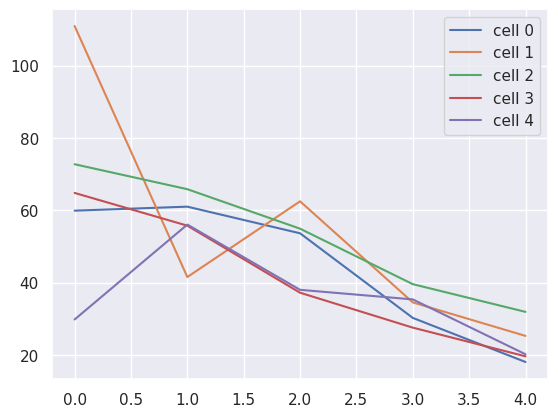

In [ ]:
run_fd(clients, num_rounds=5)

In [1]:
print("Train loss: ", 20.478680056912896+25.054552533442045+38.2003549886409+20.671978428180484+20.065945019006755)
print("Test loss: ", 18.04986937367368+25.26672856966349+31.90835220009778+19.620640038647057+20.18560807626985)

Train loss:  124.47151102618307
Test loss:  115.03119825835185


30/30 [==============================] - 1s 47ms/step
MSE for cell 0:  18.759039279062275
30/30 [==============================] - 2s 50ms/step
MSE for cell 1:  25.95957817556711
30/30 [==============================] - 1s 35ms/step
MSE for cell 2:  31.909433283974025
30/30 [==============================] - 1s 35ms/step
MSE for cell 3:  19.40480888450998
30/30 [==============================] - 1s 43ms/step
MSE for cell 4:  21.575507640570077


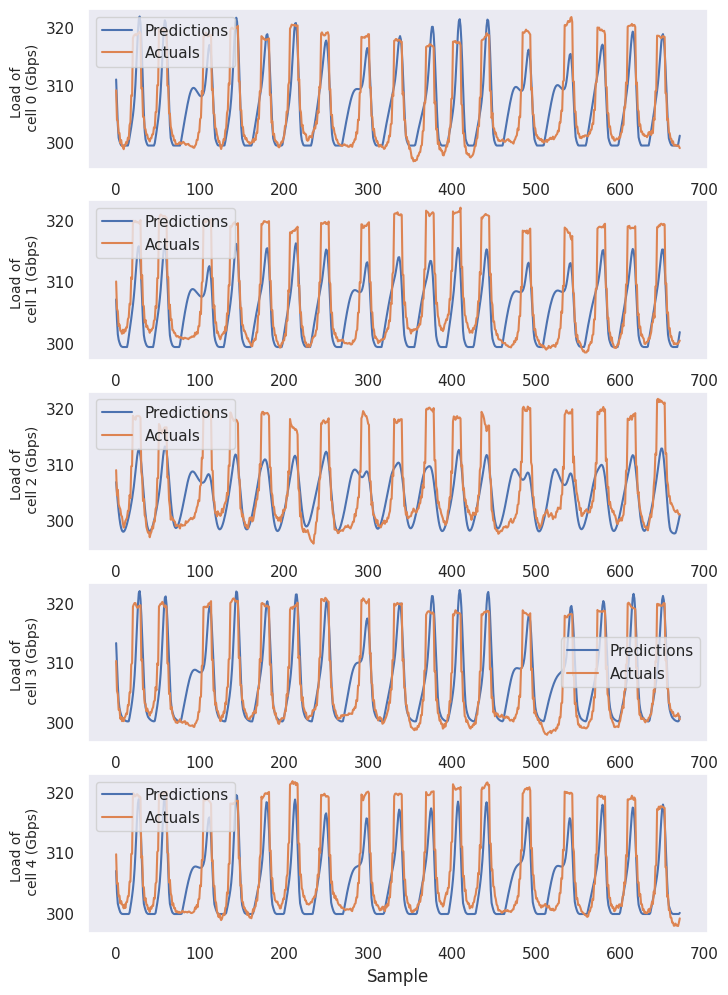

In [ ]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()
plt.show()

# POW

In [ ]:
clients = initialize_clients(num_clients=5, adjacent_metrix=adjacent_metrix, client_selection="pow")

Initializing clients ...
Neighbour for client 0: [0, 2, 4]
client 0 initilized.
Neighbour for client 1: [1, 3, 4]
client 1 initilized.
Neighbour for client 2: [0, 2, 3]
client 2 initilized.
Neighbour for client 3: [1, 2, 3]
client 3 initilized.
Neighbour for client 4: [0, 1, 4]
client 4 initilized.
Clients initialized!


round 0 client 0: 
30/30 [==============================] - 2s 34ms/step
adjacent_weight:  [(0, 0.2878928523642744), (1, 0.0), (2, 0.41643588747210986), (3, 0.0), (4, 0.29567126016361567)]
48/48 - 16s - loss: 0.1241 - root_mean_squared_error: 0.3523 - val_loss: 0.0970 - val_root_mean_squared_error: 0.3114 - 16s/epoch - 336ms/step
118/118 [==============================] - 4s 35ms/step
round 0 client 1: 
30/30 [==============================] - 1s 46ms/step
adjacent_weight:  [(0, 0.0), (1, 0.3495911076494484), (2, 0.0), (3, 0.31663496075831704), (4, 0.33377393159223456)]
48/48 - 14s - loss: 0.1333 - root_mean_squared_error: 0.3651 - val_loss: 0.1015 - val_root_mean_squared_error: 0.3185 - 14s/epoch - 286ms/step
118/118 [==============================] - 4s 35ms/step
round 0 client 2: 
30/30 [==============================] - 1s 46ms/step
adjacent_weight:  [(0, 0.12904373485135945), (1, 0.0), (2, 0.5244996865636058), (3, 0.3464565785850348), (4, 0.0)]
48/48 - 14s - loss: 0.1040 - root_me

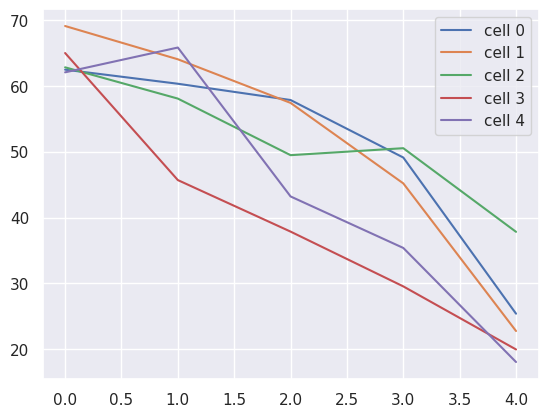

In [ ]:
run_fd(clients, num_rounds=5)

In [4]:
print("Train loss: ", 26.671927631659344 + 23.487574223379397+21.209457889120877+21.209457889120877+19.20262401041438)
print("Test loss: ", 25.39815369176275 +22.767499635846605 +19.967296738608184+19.967296738608184+18.061599840064737)

Train loss:  111.78104164369486
Test loss:  106.16184664489046


30/30 [==============================] - 1s 45ms/step
MSE for cell 0:  26.74944084018925
30/30 [==============================] - 2s 49ms/step
MSE for cell 1:  23.37928226433858
30/30 [==============================] - 1s 34ms/step
MSE for cell 2:  37.319351098614995
30/30 [==============================] - 1s 35ms/step
MSE for cell 3:  18.919627247007767
30/30 [==============================] - 1s 33ms/step
MSE for cell 4:  18.50572439681263


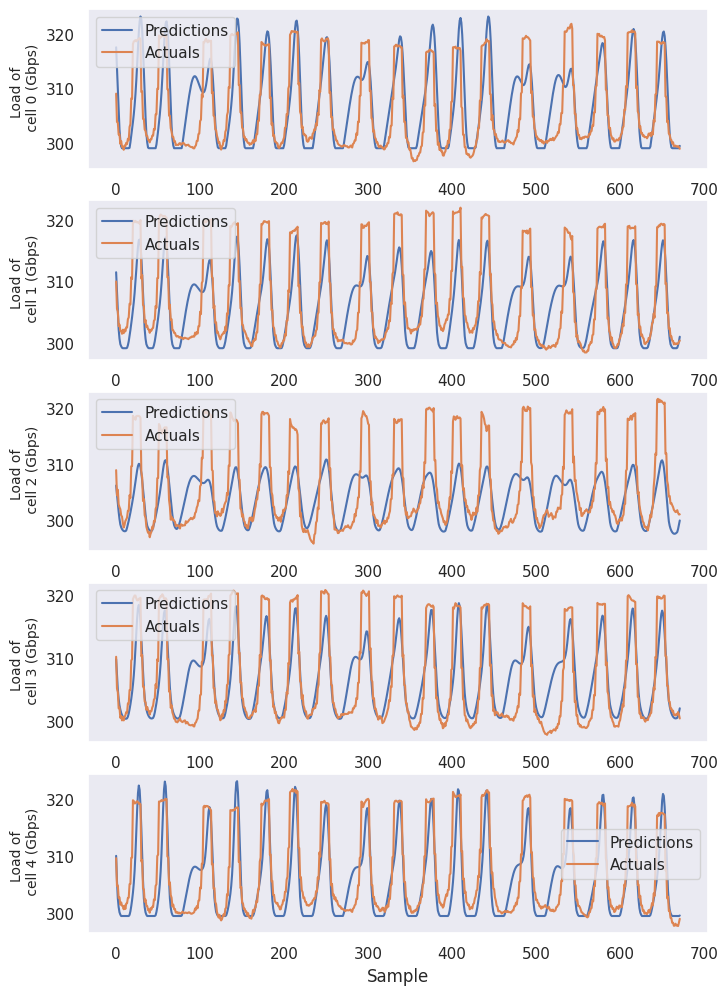

In [ ]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()
plt.show()

# DivFL

In [ ]:
clients = initialize_clients(num_clients=5,adjacent_metrix=adjacent_metrix,client_selection="div")

Initializing clients ...
Neighbour for client 0: [0, 2, 4]
client 0 initilized.
Neighbour for client 1: [1, 3, 4]
client 1 initilized.
Neighbour for client 2: [0, 2, 3]
client 2 initilized.
Neighbour for client 3: [1, 2, 3]
client 3 initilized.
Neighbour for client 4: [0, 1, 4]
client 4 initilized.
Clients initialized!


round 0 client 0: 
Selected Client:  {0, 4}
adjacent_weight:  [(0, 0.5), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.5)]
48/48 - 13s - loss: 0.1283 - root_mean_squared_error: 0.3582 - val_loss: 0.0975 - val_root_mean_squared_error: 0.3123 - 13s/epoch - 276ms/step
118/118 [==============================] - 5s 39ms/step
round 0 client 1: 
Selected Client:  {1, 4}
adjacent_weight:  [(0, 0.0), (1, 0.5), (2, 0.0), (3, 0.0), (4, 0.5)]
48/48 - 18s - loss: 0.1201 - root_mean_squared_error: 0.3466 - val_loss: 0.1203 - val_root_mean_squared_error: 0.3469 - 18s/epoch - 370ms/step
118/118 [==============================] - 5s 46ms/step
round 0 client 2: 
Selected Client:  {0, 2}
adjacent_weight:  [(0, 0.5), (1, 0.0), (2, 0.5), (3, 0.0), (4, 0.0)]
48/48 - 14s - loss: 0.1164 - root_mean_squared_error: 0.3411 - val_loss: 0.0957 - val_root_mean_squared_error: 0.3094 - 14s/epoch - 293ms/step
118/118 [==============================] - 4s 36ms/step
round 0 client 3: 
Selected Client:  {1, 2}
adjacent_weight:  [(

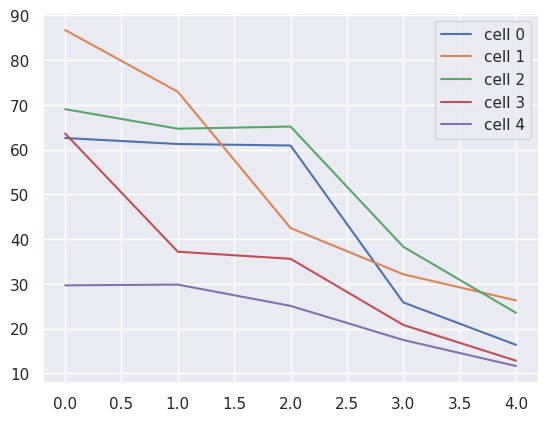

In [ ]:
run_fd(clients, num_rounds=5)

In [5]:
print("Train loss: ", 17.84743609524689 + 24.845894440410085+28.904671447565136+14.214402110970525+13.200804976058452)
print("Test loss: ", 16.374099501871473 +26.30475589319101 + 23.53061237674405 + 12.8359512713551 +11.653847696866567)

Train loss:  99.01320907025108
Test loss:  90.6992667400282


30/30 [==============================] - 1s 38ms/step
MSE for cell 0:  17.074515977907616
30/30 [==============================] - 1s 34ms/step
MSE for cell 1:  26.61571790865262
30/30 [==============================] - 1s 34ms/step
MSE for cell 2:  23.052939999678028
30/30 [==============================] - 1s 48ms/step
MSE for cell 3:  13.104057077520698
30/30 [==============================] - 1s 47ms/step
MSE for cell 4:  11.855909986791625


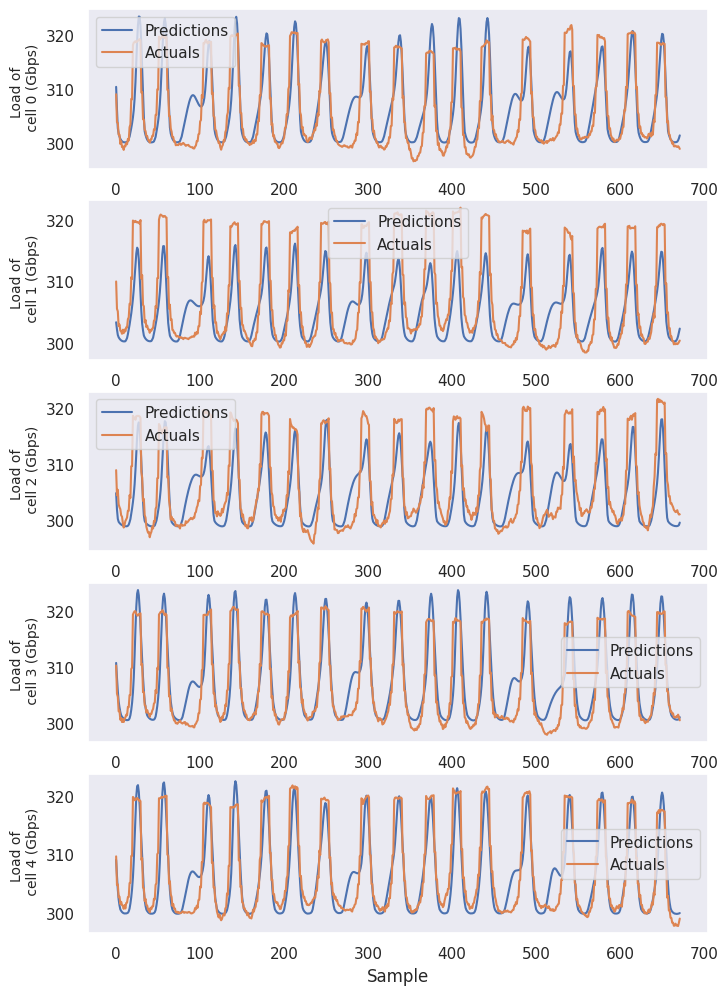

In [ ]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()
plt.show()

# Attack


In [ ]:
clients = initialize_clients(num_clients=5,adjacent_metrix=adjacent_metrix,client_selection="pow")

Initializing clients ...
Neighbour for client 0: [0, 2, 4]
client 0 initilized.
Neighbour for client 1: [1, 3, 4]
client 1 initilized.
Neighbour for client 2: [0, 2, 3]
client 2 initilized.
Neighbour for client 3: [1, 2, 3]
client 3 initilized.
Neighbour for client 4: [0, 1, 4]
client 4 initilized.
Clients initialized!


In [ ]:
# set client 2 as a compromised client
clients[2].set_compromised()
clients[2].compromised

True

MSE for cell 2:  137.49860287559474


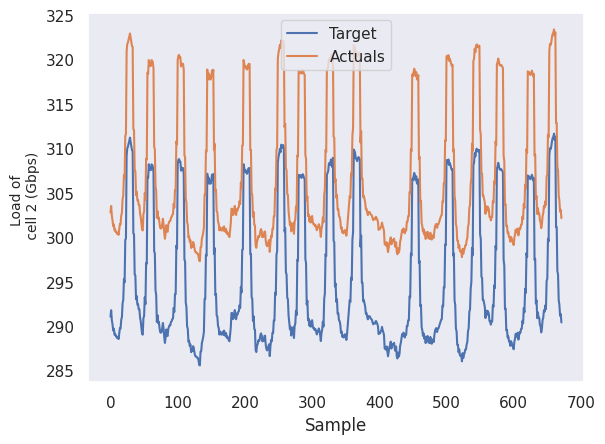

In [ ]:
y_true = clients[2].y_train
y_targeted = clients[2].y_targeted

cell_result = pd.DataFrame(data={'Targeted':y_targeted.reshape(y_targeted.shape[0]), 'Actuals':y_true.reshape(y_true.shape[0])})

print(f"MSE for cell {2}: ", mean_squared_error(y_pred=clients[2].scaler.inverse_transform(cell_result['Targeted'][:week].to_numpy().reshape(-1,1)),
                                                  y_true=clients[2].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
plt.plot(clients[2].scaler.inverse_transform(cell_result['Targeted'][:week].to_numpy().reshape(-1,1)),label="Target")
plt.plot(clients[2].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
plt.xlabel("Sample")
plt.ylabel(f"Load of \n cell {2} (Gbps)", fontsize=10)
plt.legend()
plt.show()

round 0 client 0: 
30/30 [==============================] - 2s 36ms/step
adjacent_weight:  [(0, 0.29629561820169614), (1, 0.0), (2, 0.4276127140982967), (3, 0.0), (4, 0.27609166770000704)]
48/48 - 13s - loss: 0.1023 - root_mean_squared_error: 0.3198 - val_loss: 0.0926 - val_root_mean_squared_error: 0.3043 - 13s/epoch - 262ms/step
118/118 [==============================] - 4s 31ms/step
round 0 client 1: 
30/30 [==============================] - 1s 31ms/step
adjacent_weight:  [(0, 0.0), (1, 0.35084239341133105), (2, 0.0), (3, 0.3609136733016136), (4, 0.2882439332870553)]
48/48 - 13s - loss: 0.1269 - root_mean_squared_error: 0.3562 - val_loss: 0.1041 - val_root_mean_squared_error: 0.3226 - 13s/epoch - 266ms/step
118/118 [==============================] - 4s 31ms/step
round 0 client 2: 
adjacent_weight:  [(0, 0.0), (1, 0.0), (2, 1.0), (3, 0.0), (4, 0.0)]
118/118 [==============================] - 4s 36ms/step
48/48 - 13s - loss: 0.0723 - root_mean_squared_error: 0.2689 - val_loss: 0.0780 -

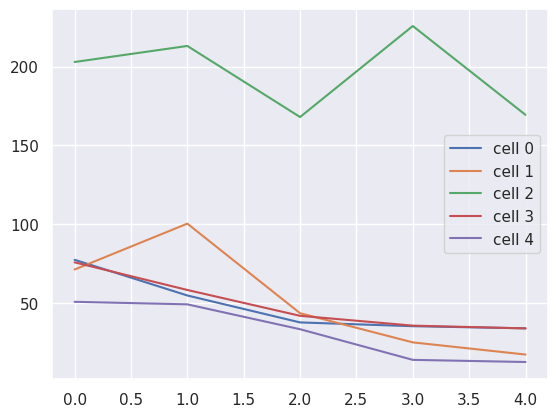

In [ ]:
run_fd(clients, num_rounds=5)

In [6]:
print("Train loss: ", 13.68558555547651 + 16.264104282692685+180.52012764862252+11.408906599757266+11.941362373020464)
print("Test loss: ", 34.2041138194854 +17.599661697647445 + 169.38410045945432 + 34.156071952270096 + 12.875180599415168)

Train loss:  233.82008645956947
Test loss:  268.21912852827245


30/30 [==============================] - 1s 34ms/step
MSE for cell 0:  33.34760316909786
30/30 [==============================] - 1s 34ms/step
MSE for cell 1:  17.645791584618973
30/30 [==============================] - 1s 38ms/step
MSE for cell 2:  167.75720352298134
30/30 [==============================] - 1s 46ms/step
MSE for cell 3:  29.671183098072667
30/30 [==============================] - 1s 39ms/step
MSE for cell 4:  13.924538732558844


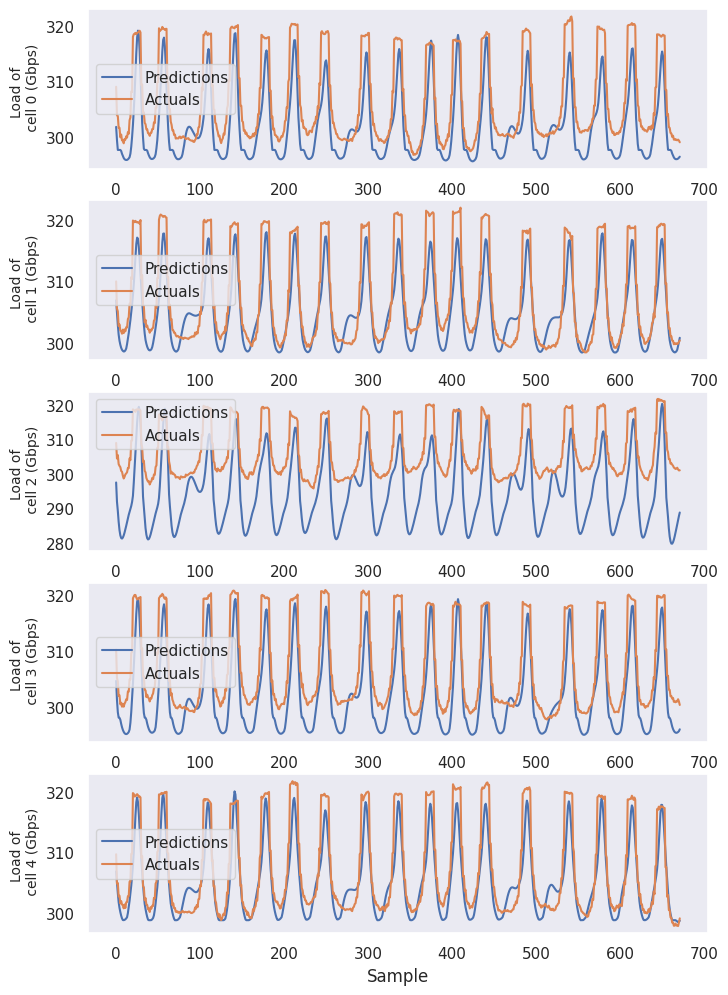

In [ ]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()
plt.show()

# Anomaly detection

In [ ]:
clients = initialize_clients(num_clients=5, adjacent_metrix=adjacent_metrix, client_selection="pow")

Initializing clients ...
Neighbour for client 0: [0, 2, 4]
client 0 initilized.
Neighbour for client 1: [1, 3, 4]
client 1 initilized.
Neighbour for client 2: [0, 2, 3]
client 2 initilized.
Neighbour for client 3: [1, 2, 3]
client 3 initilized.
Neighbour for client 4: [0, 1, 4]
client 4 initilized.
Clients initialized!


In [ ]:
# set client 2 as a compromised client
clients[2].set_compromised()
clients[2].compromised

True

In [ ]:
# # set client 0 as a robust client
clients[0].set_robustness()
clients[0].robustness

True

round 0 client 0: 
30/30 [==============================] - 2s 30ms/step
client 0 sum: 157.4280488307058 
client 2 sum: 207.5585359362419 
client 4 sum: 142.9815734954685 
30/30 [==============================] - 1s 34ms/step
adjacent_weight:  [(0, 0.30991715970783057), (1, 0.0), (2, 0.40860540677633816), (3, 0.0), (4, 0.28147743351583127)]
48/48 - 13s - loss: 0.1290 - root_mean_squared_error: 0.3592 - val_loss: 0.1004 - val_root_mean_squared_error: 0.3169 - 13s/epoch - 261ms/step
118/118 [==============================] - 4s 31ms/step
round 0 client 1: 
30/30 [==============================] - 1s 30ms/step
adjacent_weight:  [(0, 0.0), (1, 0.335268796849454), (2, 0.0), (3, 0.3628009112060458), (4, 0.3019302919445004)]
48/48 - 12s - loss: 0.1290 - root_mean_squared_error: 0.3592 - val_loss: 0.1001 - val_root_mean_squared_error: 0.3164 - 12s/epoch - 257ms/step
118/118 [==============================] - 5s 41ms/step
48/48 - 13s - loss: 0.0708 - root_mean_squared_error: 0.2660 - val_loss: 

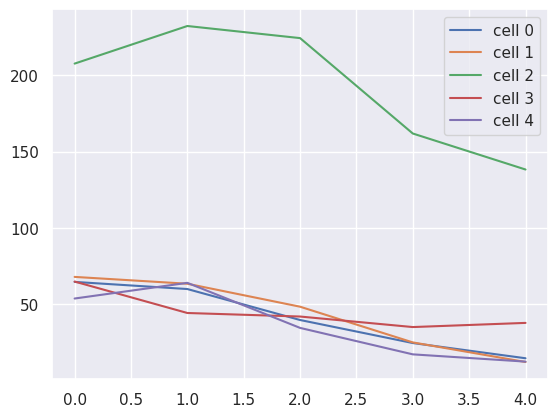

In [ ]:
run_fd(clients, num_rounds=5)

In [7]:
print("Train loss: ", 16.48719772781065 + 11.894975206056266+147.7456053489723+11.066254004204147+13.25512928259425)
print("Test loss: ", 14.657557713260482 +12.202733227004991 + 138.32823657891927 + 37.82949672782504 + 12.459660126279953)

Train loss:  200.44916156963762
Test loss:  215.47768437328972


30/30 [==============================] - 1s 31ms/step
MSE for cell 0:  14.921523525721645
30/30 [==============================] - 1s 31ms/step
MSE for cell 1:  12.330512767346871
30/30 [==============================] - 1s 31ms/step
MSE for cell 2:  135.91994180601046
30/30 [==============================] - 1s 31ms/step
MSE for cell 3:  33.15251578245639
30/30 [==============================] - 1s 31ms/step
MSE for cell 4:  12.71034048457806


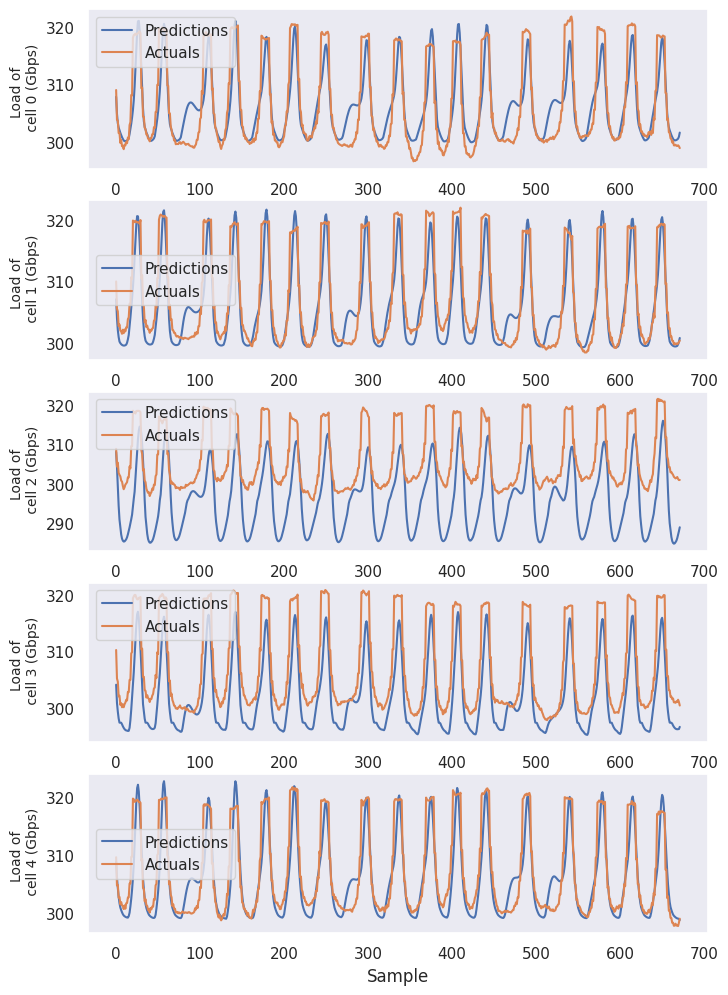

In [ ]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()
plt.show()

#Full Robust


In [24]:
clients = initialize_clients(num_clients=5, adjacent_metrix=adjacent_metrix, client_selection="pow")

Initializing clients ...
Neighbour for client 0: [0, 2, 4]
client 0 initilized.
Neighbour for client 1: [1, 3, 4]
client 1 initilized.
Neighbour for client 2: [0, 2, 3]
client 2 initilized.
Neighbour for client 3: [1, 2, 3]
client 3 initilized.
Neighbour for client 4: [0, 1, 4]
client 4 initilized.
Clients initialized!


In [25]:
# set client 2 as a compromised client
clients[2].set_compromised()
clients[2].compromised

True

In [26]:
# # set client 0 as a robust client
clients[0].set_robustness()
clients[3].set_robustness()

round 0 client 0: 
30/30 [==============================] - 3s 42ms/step
client 0 sum: 162.64818430410128 
client 2 sum: 212.4101558555038 
client 4 sum: 146.05024410235507 
30/30 [==============================] - 1s 32ms/step
adjacent_weight:  [(0, 0.31211956436000365), (1, 0.0), (2, 0.4076120836818256), (3, 0.0), (4, 0.28026835195817057)]
48/48 - 12s - loss: 0.1381 - root_mean_squared_error: 0.3716 - val_loss: 0.0994 - val_root_mean_squared_error: 0.3152 - 12s/epoch - 253ms/step
118/118 [==============================] - 4s 32ms/step
round 0 client 1: 
30/30 [==============================] - 1s 32ms/step
adjacent_weight:  [(0, 0.0), (1, 0.3590739023738953), (2, 0.0), (3, 0.3287236652742323), (4, 0.3122024323518724)]
48/48 - 12s - loss: 0.1271 - root_mean_squared_error: 0.3565 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3318 - 12s/epoch - 252ms/step
118/118 [==============================] - 4s 32ms/step
round 0 client 2: 
adjacent_weight:  [(0, 0.0), (1, 0.0), (2, 1.0), (3,

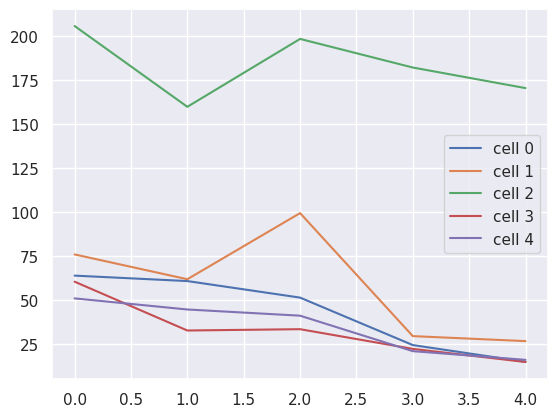

In [27]:
run_fd(clients, num_rounds=5)

In [10]:
print("Train loss: ", 16.90298104155446 + 25.350957463079574+ 47.7456053489723+ 15.888343648324296 + 16.299557277679476)
print("Test loss: ", 14.845706326766432 +26.60658164302929 + 38.32823657891927 + 14.73197183442818 + 15.954249652885839)

Train loss:  122.1874447796101
Test loss:  110.46674603602901


30/30 [==============================] - 1s 38ms/step
MSE for cell 0:  15.335871044212555
30/30 [==============================] - 1s 32ms/step
MSE for cell 1:  27.099553425343444
30/30 [==============================] - 1s 33ms/step
MSE for cell 2:  168.4357789106043
30/30 [==============================] - 1s 30ms/step
MSE for cell 3:  14.346566747845568
30/30 [==============================] - 1s 31ms/step
MSE for cell 4:  16.121624179977864


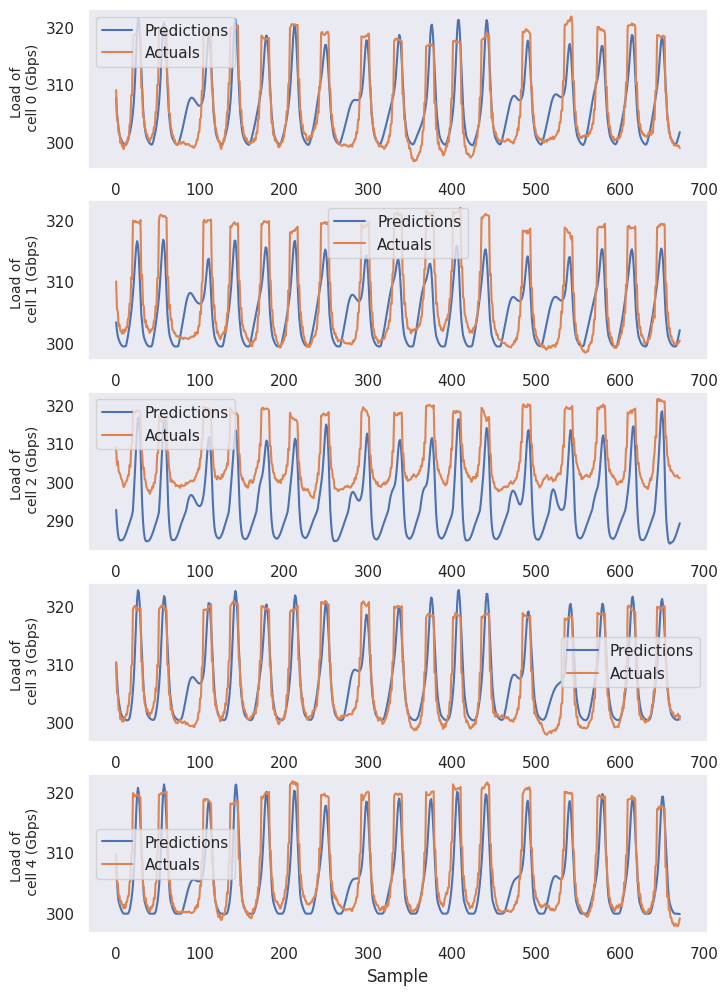

In [28]:
plt.figure(figsize=(8, 12))

for cid in range(len(clients)):
  x_test = clients[cid].x_test
  y_test = clients[cid].y_test
  y_pred = clients[cid].predict(x_test)

  cell_result = pd.DataFrame(data={'Test Predictions':y_pred, 'Actuals':y_test.reshape(y_test.shape[0])})

  print(f"MSE for cell {cid}: ", mean_squared_error(y_pred=clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),
                                                    y_true=clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1))))
  plt.subplot(5, 1, cid+1)
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Test Predictions'][:week].to_numpy().reshape(-1,1)),label="Predictions")
  plt.plot(clients[cid].scaler.inverse_transform(cell_result['Actuals'][:week].to_numpy().reshape(-1,1)),label="Actuals")
  plt.xlabel("Sample")
  plt.ylabel(f"Load of \n cell {cid} (Gbps)", fontsize=10)
  plt.legend()
plt.show()